# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [35]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

%matplotlib inline

Прочитаем исходные данные:

In [36]:
data = pd.read_csv('unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

*Проверим на наличие пропусков наши данные*

In [37]:
data.isnull().sum()

Well       0
Por        0
Perm       0
AI         0
Brittle    0
TOC        0
VR         0
Prod       0
dtype: int64

*Пропусков нет. Посмотрим на распределения всех признаков в т.ч. целевого*

In [38]:
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


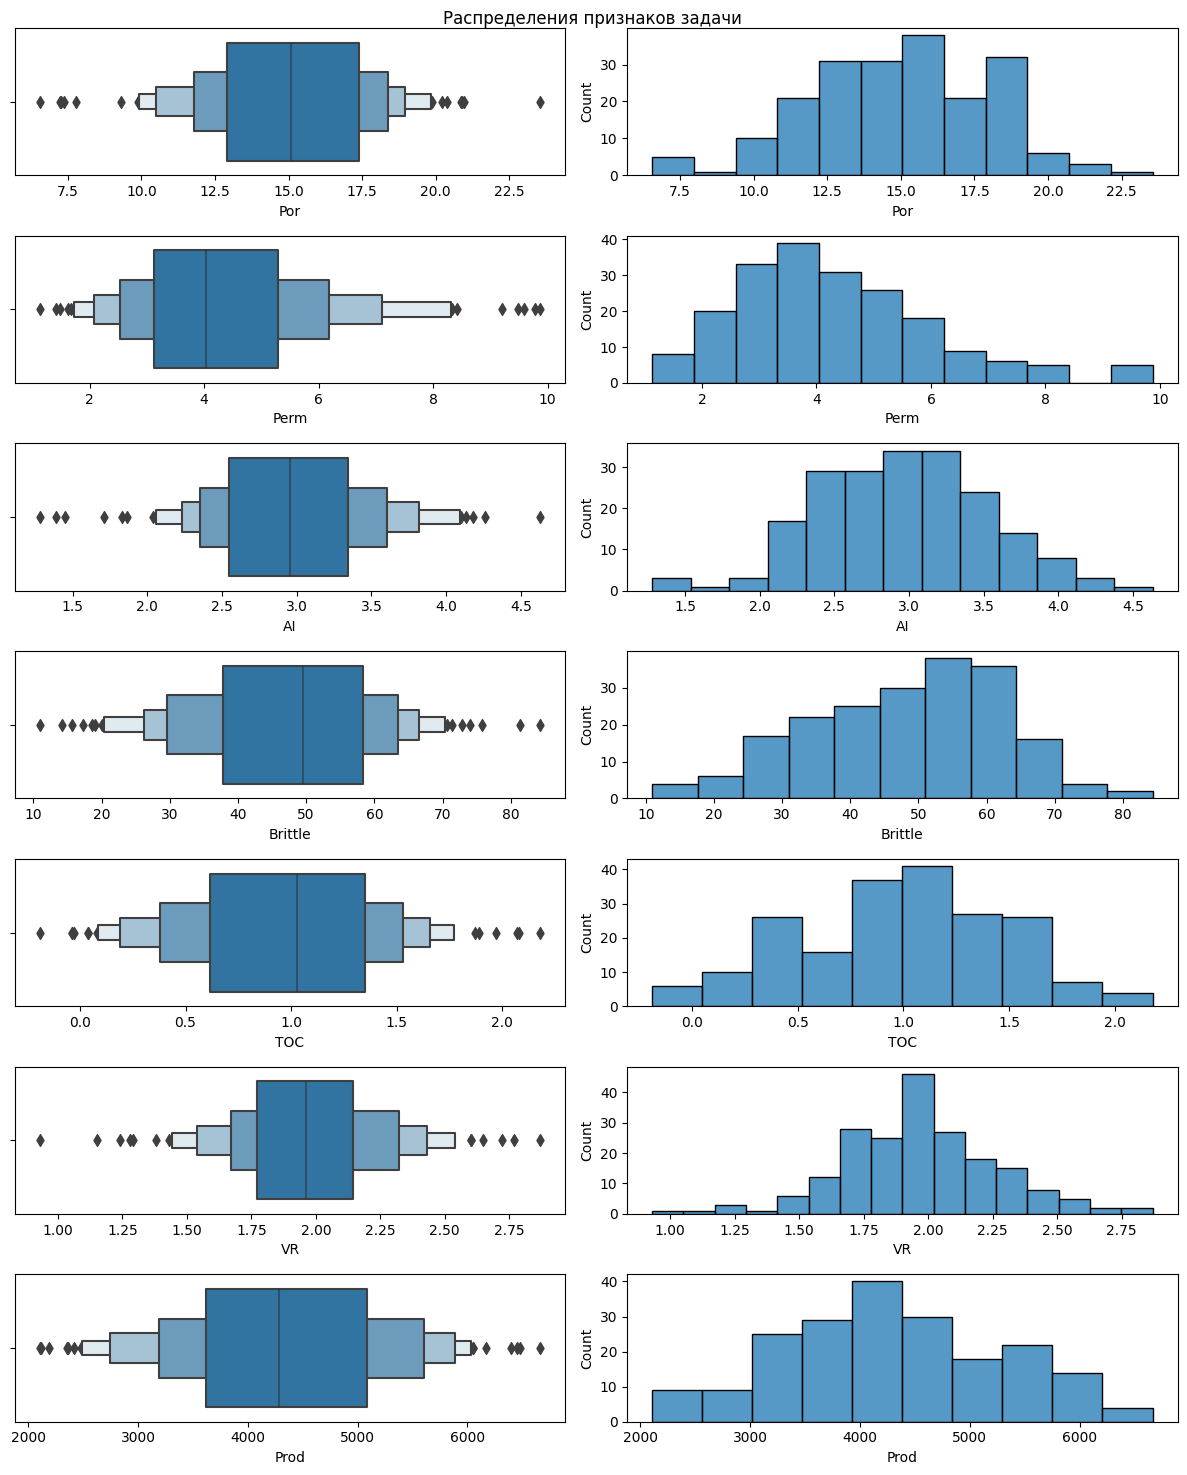

In [39]:
features = list(data.columns)[1:] #сделаем список фич, для удобства и выкинем из него номер скважины, как неинформативный
n = len(features) 
#Создадим по паре очей на каждый признак, чтобы посмотреть распределение 2мя графиками: гистограммой и коробчатой диараммой
fig, axes = plt.subplots(n,2,  figsize=(12, 15)) 
#Создаем цикл для всех признаков и рисуем заявленные диаграммы
for i,feature in enumerate(features):
    sns.boxenplot(x=data[feature], ax=axes[i][0])
    sns.histplot(x=data[feature], ax=axes[i][1])

fig.suptitle('Распределения признаков задачи')
plt.tight_layout() #выравнивание графиков

*Я бы сказал, что признаки распределены "хорошо", выбросов особо нет.*
*Посмотрим теперь попарные диграммы рассеяния.*

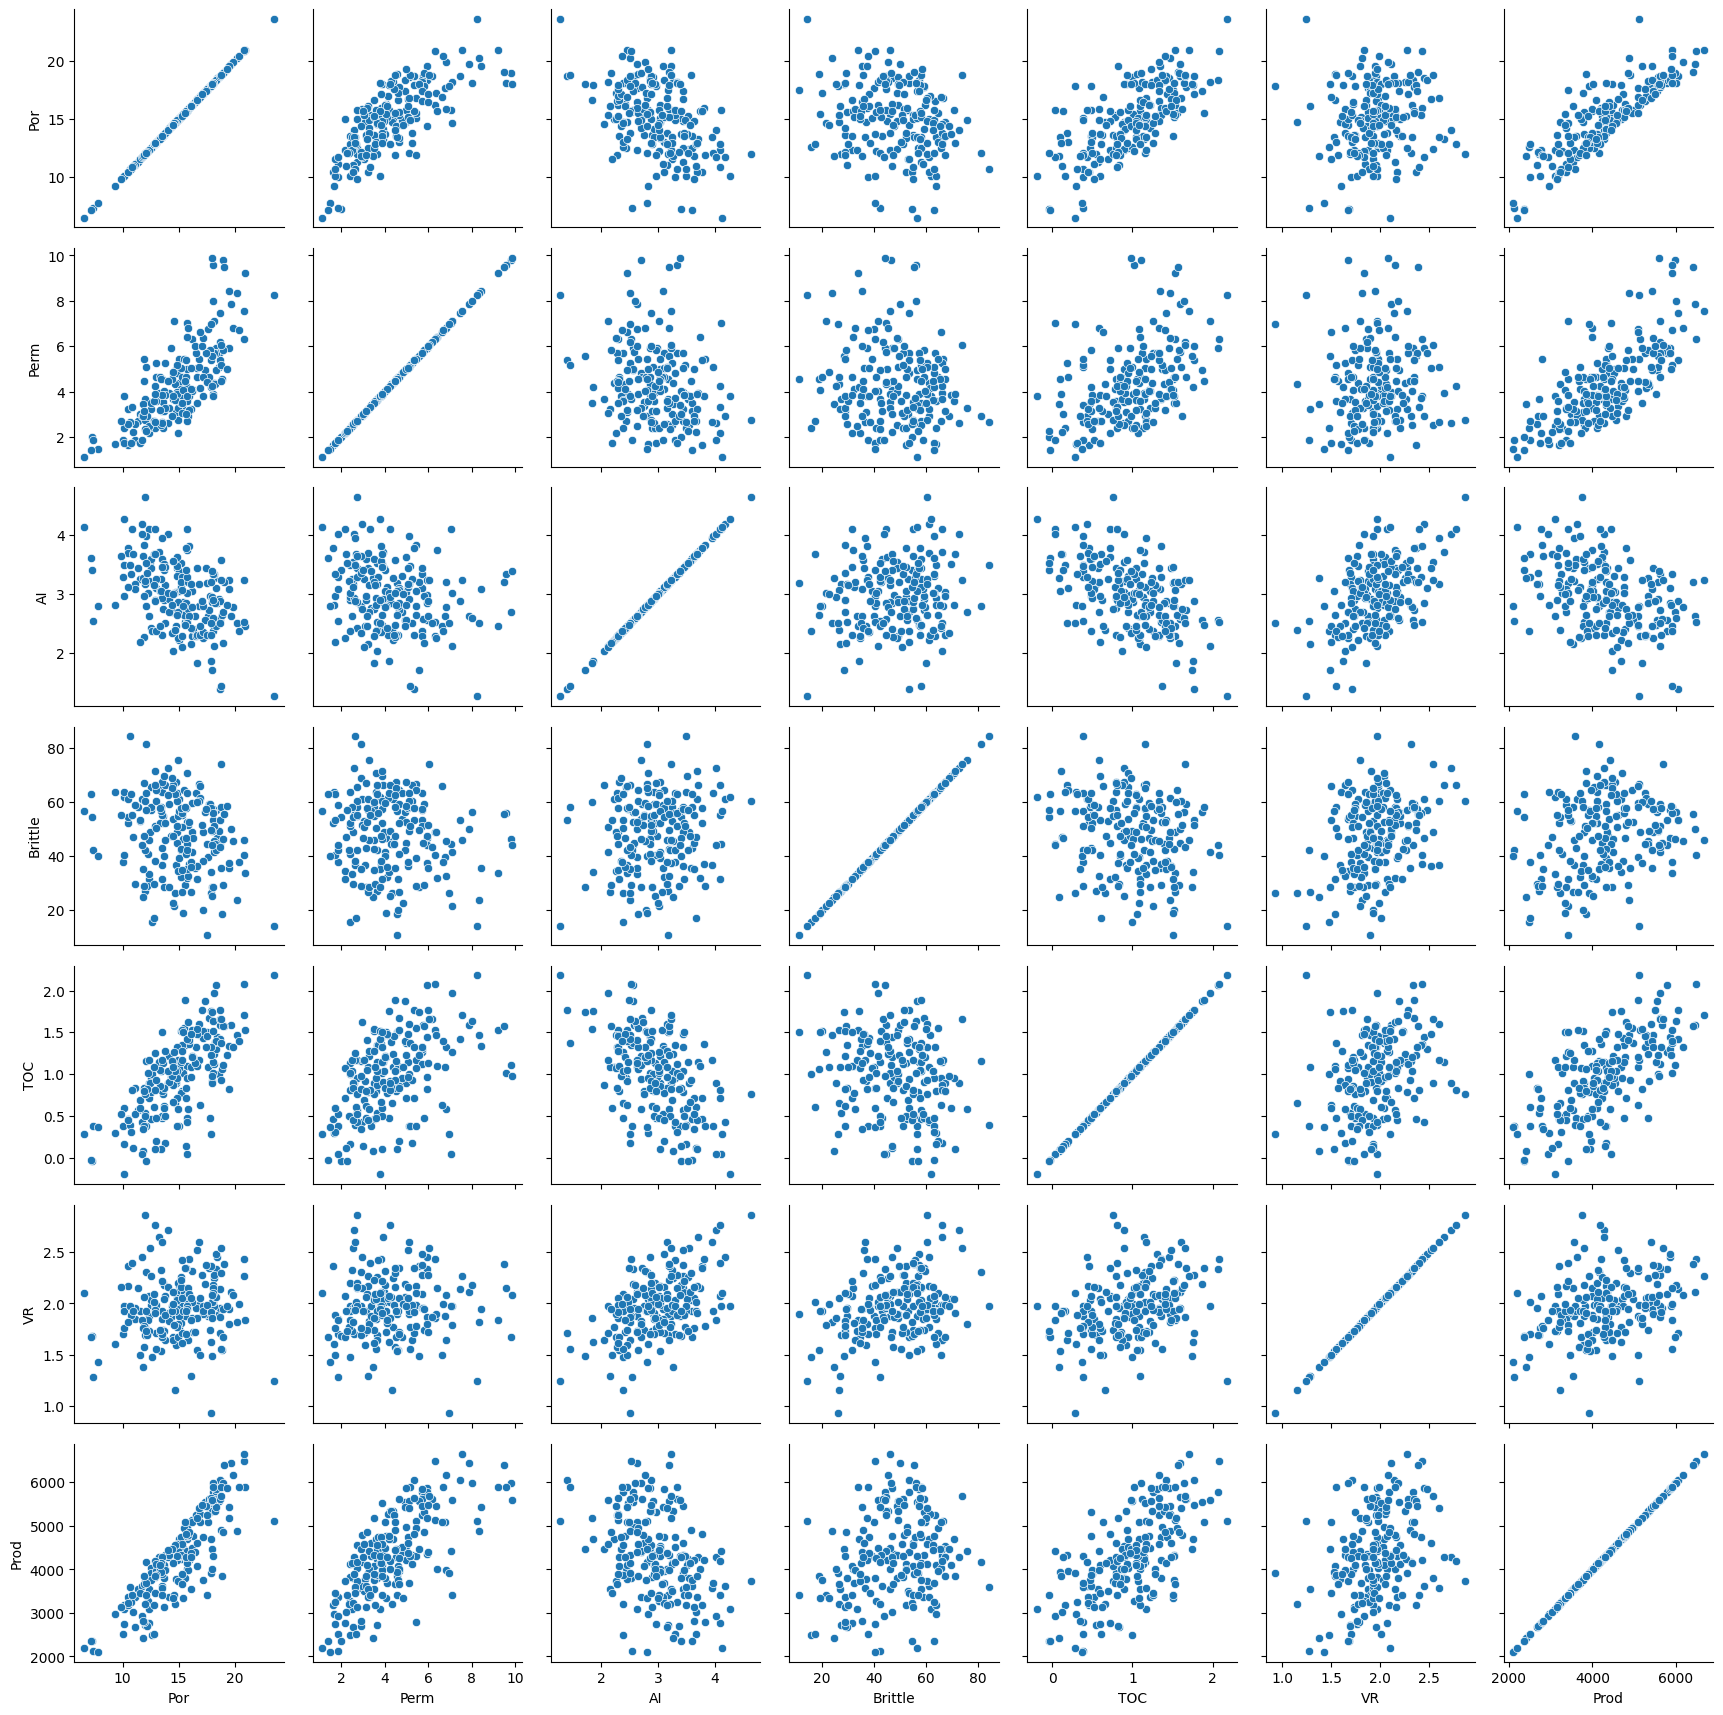

In [40]:
g = sns.PairGrid(data[features])
g.map(sns.scatterplot)

*Посмотрим сначала на диаграммы рассеяния с целевым признаком Prod:*
* *Есть выраженная прямая корреляция с признаками Por (и очень сильная), а также Perm и TOC. Они возможно значимы для построения модели*
* *Есть не очень сильная, но заметная обратная корреляция с AI. Тоже, возможно важный признак*
* *По значимости Brittle и VR сказать что-то сложно*

*Посмотрим на скоррелированные прямо или обратно пары признаков-факторов:
* *Perm/Por/TOC - есть попарная корреляция, а еще и с целевым признаком. Надо быть аккуртаным - все важны, но есть риск мультиколлерианости*
* *Есть заметная обратная корреляция TOC и AI, но тут у меня пока нет гипотез, как это может сказаться на итоговой модели*

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [41]:
# Построим корреляционную матрицу факторов. Сделаем это сначала руками, а потом методом corr
A = data[features] 
A_st = A - A.mean()
A_st = A_st / np.linalg.norm(A_st, axis=0)
#вычислим разницу меджу матрицами как сумму квадратом всех значений матриц корреляций посчитанной вручную и через corr()
A_corr = A_st.T@A_st
np.linalg.norm(A_corr - A.corr()) 

2.006696445460063e-15

*Можно сказать, что мы убедились, что метод corr идентичен подсчету матрицы корреляций вручную. Что и следовало ожидать. Сделал это ради интереса. Теперь перейдем к выполнению задания и заодно параллельно посчитал корреляционную иатрицу вручную, как и требовалось в задании*

<AxesSubplot: >

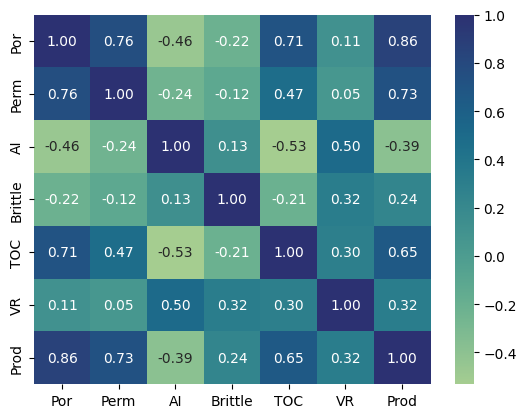

In [42]:
sns.heatmap(A_corr, annot=True, fmt=".2f", cmap="crest")

*Корреляция с целевой переменной*

*В порядке убывания Por, Perm, TOC как сильно значимые. Вторым эшелоном гораздо более низкую зависимость показявают обратная корреляция с AI, потом прямые c VR и Bittle.*
*Тепловая карта более наглядно показала тоже самое, что было видно из диаграмм рассеяния в п 5.0, как и следовало ожидать.*

*Теперь изучим корреляционную матрицу*

In [43]:
print(f'Ранг корреляционной матрицы с включенным целевым признаком равен: {np.linalg.matrix_rank(A_corr)}')
print(f'Определитель корреляционной матрицы с включенным целевым признаком равен: {np.linalg.det(A_corr)}')
print(f'Ранг корреляционной матрицы по факторам (без целевого признака): {np.linalg.matrix_rank(data[features[:-1]].corr())}')
print(f'Определитель корреляционной матрицы по факторам (без целевого признака): {np.linalg.det(data[features[:-1]].corr())}')

Ранг корреляционной матрицы с включенным целевым признаком равен: 7
Определитель корреляционной матрицы с включенным целевым признаком равен: 0.000747768498802248
Ранг корреляционной матрицы по факторам (без целевого признака): 6
Определитель корреляционной матрицы по факторам (без целевого признака): 0.018620704143012656


Выводы:

* *Корреляционная матрица невырождена. Вот прям линейно зависимых признаков не наблюдается*
* *Определитель матрицы, которую мы будем обращать (без целевого признака) достаточно мал. Если честно, я не знаю насколько критичен этот порядок малости (2е-2) и является ли это признаком плохой обусловленности. Скорее да, чем нет. Возможно имеет смыл проверить насколько большие и логичные значения коэффицентов линейной регрессии получатся при моделировании, чтобы сделать окончательный вывод.*

**Примечание**
* *На платформе ранг корреляционной матрицы предполагается посчитанным по всем признакам, в том числе и по порядковому номеру скважины. Если честно, я не очень понимаю, зачем включать порядковый номер. Я при построении диаграмм рассеяния, проверял этот признак,а потом убрал - там ожидаемо хаос полный и его исключил сразу из расчетов выше.*
* *Более того, я не понял, зачем включать вектор правильных ответов при анализе определителя корреляционной матрицы. Ведь на самом деле мы хотим, чтобы его корреляция с факторами была высокая как раз, а обращать мы будем матрицу Грама (или стандартизированную матрицу Грама) именно фаткоров, а не целевого признака. Поэтому нам важен скорее определитель корреляционной матрицы по факторам.*

***Просьба проверяющего ментора дать комментарии по этим рассуждениям в обратной связи к заданию. Верна ли моя логика?***

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [44]:
#По заданию дальше пока работаем на всех признаках
X = data.drop(['Prod'], axis = 1)
y = data['Prod']
#Добавем признак из единиц
X = np.array(X)
X = np.column_stack((np.ones(X.shape[0]), X))
#Построим аналитическое решение по МНК вручную (по формуле по сути)
w = np.linalg.inv(X.T@X)@X.T@y
pd.DataFrame(w, index=['w0',*list(data.drop(['Prod'], axis=1).columns)]).round(0) #выведем на экран окрегденные значения коэффицентов регрессии

,0
w0,-1232.0
Well,0.0
Por,230.0
Perm,116.0
AI,-365.0
Brittle,25.0
TOC,-78.0
VR,785.0


***Выводы:***
* *Признак Well неинформативен. Собственно так и ожидалось. Я вообще его исключил на старте в 5.0, когда предварительный анализ делал... Это же просто порядковый номер!*
* *При увеличении пористости на 1%, скважина даже плюсом 230 млн кубически футов в сутки*
* *При увеличении VR на 1%, скважина дает плюсом аж 785 млн кубических футов в сутки*
* *Может показаться, что признак VR более значимый, а корреляция говорила об обратном. Так вот корреляция я все еще думаю, что корреляция была права. Не смотря на измерение в % масштаб признаков тут разный. VR меняется в пределах примерно 1-3% с небольшим разбросом причем, а Por где-то от 7,5% до 23,5% с большей вариацией.*

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [45]:
x_new = np.array([1, 106 ,15.32, 3.71, 3.29, 55.99, 1.35, 2.42]) #вектор новой скважины для прогноза. 
#Единицу спереди добавили, т.к. наша модель работает на данных до стандартизации и w0 не ноль с модели как следствие
y_pred_new = x_new@w
print(f'Прогноз для x_new = {y_pred_new}')
print(f'MAE (абсолютная ошибка) для новой скважины = {np.abs(y_pred_new - 4748.315024)}')

#Выберем метрики МАЕ и МАРЕ. 
#Они обе подходят и легко интерпретируемы и для нас и для заказчика. И в целом обе про одно, только в разных единицах.
import sklearn.metrics
print(f'MAE (абсолютная ошибка) для обучающей выборки = {sklearn.metrics.mean_absolute_error(X@w,y)}')
print(f'MAРE (абсолютная ошибка в %) для обучающей выборки = {sklearn.metrics.mean_absolute_percentage_error(X@w,y)*100}')


Прогноз для x_new = 4723.064053707427
MAE (абсолютная ошибка) для новой скважины = 25.250970292573584
MAE (абсолютная ошибка) для обучающей выборки = 153.62297086555915
MAРE (абсолютная ошибка в %) для обучающей выборки = 3.6116459849674523


***Выводы***

*Моделирование оказалось очень точным. 3,61% средней ошибки - это потрясающе. Я бы сказал, что зависимость в данных, видимо, близка к линейной, и поэтому в линейная регрессия работает очень точно. Хотя надо признать, что мы смотрим на обучающей выборке по сути, а тестовой у нас нет. Поэтому теоретически есть вероятность переобучения и мы не можем ее проверить, т.к. нужны тестовые данные, но в переобучение линейной регресии вериться мне слабо. Сама по себе модель не склонна к переобучению, если мы не используем полимиальный вариант*

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [46]:
# Чтобы выполнить задание, составим табличку "название фактора", 
# "Значение коэффицента wi" в получившейся модели, Значение корреляции данного фактора с целевым признаком
column_corr = np.array([0,*list(data.corr()['Prod'].values)[:-1]])
Table = pd.DataFrame(w, index=['w0',*list(data.drop(['Prod'], axis=1).columns)]).round(0)
Table['corr'] = column_corr
Table


,0,corr
w0,-1232.0,0.000000
Well,0.0,0.026817
Por,230.0,0.861910
Perm,116.0,0.727426
AI,-365.0,-0.390835
Brittle,25.0,0.237155
TOC,-78.0,0.654445
VR,785.0,0.323182


***Выводы***

*Фактор TOC примечателен тем, что у него прямая корреляция с целевым признаком, а коэффицент регресии отрицательный. При этом мы имеем разумные коэффиценты в целом. Я так думаю, что это из-за произошло из-за мультиколлериарности (это единсвенное объяснение, которое приходит на ум). У меня такая гипротеза: определитель матрицы корреляций недостаточно близок к нулю, чтобы превратить коэффиценты регересии в заоблачно большие, но достаточно близка к нулю, чтобы "испортить" логическую прямую зависимость TOC и целевого признака*

***Просьба проверяющего ментора дать комментарии по этим рассуждениям в обратной связи к заданию. Верна ли моя логика?***

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [47]:
#Удалим из модели признаки TOC и Perm, как сильно скоррелированные с Por 
#(Оставляем Por т.к. его корреляция с целвым признаком макимальна из этих 3х) 
#а также сразу уберем Well из модели (порядковый номер)
X = data.drop(['Prod','TOC','Perm','Well'], axis = 1)
y = data['Prod']
#Добавем признак из единиц
X = np.array(X)
X = np.column_stack((np.ones(X.shape[0]), X))
#Построим аналитическое решение по МНК вручную (по формуле по сути)
w = np.linalg.inv(X.T@X)@X.T@y
#Выведем коэфиценты регресии
pd.DataFrame(w, index=['w0',*list(data.drop(['Prod','TOC','Perm','Well'], axis=1).columns)]).round(0) #выведем на экран окрегденные значения коэффицентов регрессии


,0
w0,-1835.0
Por,293.0
AI,-200.0
Brittle,28.0
VR,517.0


In [48]:
#Рассчитаем метрики
print(f'MAE (абсолютная ошибка) для обучающей выборки = {sklearn.metrics.mean_absolute_error(X@w,y)}')
print(f'MAРE (абсолютная ошибка в %) для обучающей выборки = {sklearn.metrics.mean_absolute_percentage_error(X@w,y)*100}')

MAE (абсолютная ошибка) для обучающей выборки = 171.43146059580923
MAРE (абсолютная ошибка в %) для обучающей выборки = 4.064202444350766


***Выводы***

* ***Интерпретация значений w:***
    * *При увеличении пористости на 1%, скважина даже плюсом 293 млн кубически футов в сутки*
    * *При увеличении VR на 1%, скважина дает плюсом 517 млн кубических футов в сутки*
    * *Другие признаки интерпретируются аналогично*
* ***Сравним значения метрик с полуенными ранее***
    * *Точность модели на обучающей выборке немного снизилась (примерно на 0,4% по MAPE). Но это выглядит как незначительное снижение точности*
    * *Это легко объяснить, ведь факторы TOC и Perm все таки не пропорциональны полностью Por, а только сильно коррелируют с ним. А значит мы все-таки часть информации о зависимостях в данных потеряли (хотя судя по метрике ОЧЕНЬ маленькую)*
* ***Знаки коэфицентов регрессии и корреляций с целевым признаком**
    * *Единсвенным отрицательно скоррелированным с целевым был признак AI. И именно его коэффицент (кроме коэффицента свободного члена) отрицателен. Теперь модель интерпретируется более логично*

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [49]:
X = data.drop(['Prod','TOC','Perm','Well'], axis = 1)
y = data['Prod']

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X,y)

display(f'Параметры линейной регресии sklearn. w0: {model.intercept_.round(0)}, wi(1-4):  {model.coef_.round(0)}')

'Параметры линейной регресии sklearn. w0: -1835.0, wi(1-4):  [ 293. -200.   28.  517.]'

In [50]:
y_pred = model.predict(X)
print(f'MAE (абсолютная ошибка) для обучающей выборки = {sklearn.metrics.mean_absolute_error(y_pred,y)}')
print(f'MAРE (абсолютная ошибка в %) для обучающей выборки = {sklearn.metrics.mean_absolute_percentage_error(y_pred,y)*100}')

MAE (абсолютная ошибка) для обучающей выборки = 171.43146059580786
MAРE (абсолютная ошибка в %) для обучающей выборки = 4.064202444350585


In [51]:
#Выполним еще оценку метрик при кросс валидации на 5 фолдах, для финального отчета заказчику. 
#Т.к. для остальных моделей мы будем использовать кросс валидацию.
model = LinearRegression()
cross_val = cross_validate(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных данных на каждом фолде:', cross_val['train_score']*100)
print('МAPE на тестовых данных на каждом фолде:', cross_val['test_score']*100)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cross_val['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cross_val['test_score'].mean() * 100))

MAPE на тренировочных данных на каждом фолде: [-3.98856856 -4.18844655 -3.84884105 -4.04207643 -4.03786967]
МAPE на тестовых данных на каждом фолде: [-4.28608286 -3.22228075 -4.99196249 -4.33505044 -4.31963699]
MAPE на тренировочных фолдах: 4.02 %
MAPE на валидационных фолдах: 4.23 %


***Вывод***

*Получилась таже самая модель с теми же коэфицентами (и как следствие и метрики совпали). Тут наверное напрашивается сказать, что мы подтвердили, что аналитическое решение полученное вручную совпадает с аналитическим решением через sklearn*

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [52]:
#Зададим X и y на отобранных во время построения линейной модели факторах
X = data.drop(['Prod','TOC','Perm','Well'], axis = 1)
y = data['Prod']
#Стандаризум признаки 
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Генерируем полиномиальные признаки третьего порядка на факторах. Параметр `include_bias` установите в значение `False`.
poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)

#Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.
print(f'Итого у нас получилось признаков: {X.shape[1]}')

#Проверим по формуле: d = 3 степень полинома, k = 4 - число признаков
from math import factorial
print(f'Итого должно у нас получиться коэффицентов по формуле: {factorial(3+4)/(factorial(3)*factorial(4))}')

Итого у нас получилось признаков: 34
Итого должно у нас получиться коэффицентов по формуле: 35.0


Комментарий: формула работает с учетом коэфицента свободного члена, а фаторов на один меньше

In [53]:
#Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.
lr = LinearRegression()
cross_val = cross_validate(lr, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)

print('MAPE на тренировочных данных на каждом фолде:', cross_val['train_score']*100)
print('МAPE на тестовых данных на каждом фолде:', cross_val['test_score']*100)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cross_val['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cross_val['test_score'].mean() * 100))

MAPE на тренировочных данных на каждом фолде: [-1.83892169 -1.79861153 -1.78240177 -1.72603656 -1.72023082]
МAPE на тестовых данных на каждом фолде: [-2.38729479 -2.64712679 -2.48238968 -2.79199054 -3.09557545]
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


***Выводы***
*Видно, что полиномиальная регрессия решает задачу лучше, чем линейная: даже валиадацонная метрика лучше того что получалось ранее на тестовой. Однако есть большая разница между MAPE на тестовых данных и MAPE на валидационных. Есть риск того, что модель переобучена. Вполне может получиться улучшить метрику на валидационных данных, а значит снизить переобучение модели, испольщуя регуляризацию*

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [54]:
# X и y уже заданы. А X содержит полиномиальные факторы степени 3 на стандартизированных StandatdScaler факторах исходных 
#Нам надо подобрать параметр alpha. Т.к. он один, я буду строить график зависимости MAPE на 
#тестовых и обучающих данных от alpha, не используя инструменты подбора гиперпараметров.

p = list()
for a in np.linspace(0.05,8,100):
    lasso = Lasso(alpha=a, max_iter=10000)
    cv_results = cross_validate(lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
    train_mape = -cv_results['train_score'].mean()* 100
    test_mape = -cv_results['test_score'].mean() * 100
    p.append([a, train_mape, test_mape])

vis_data = pd.DataFrame(p, columns=['alpha', 'train MAPE', 'test MAPE'])

import plotly.express as px

fig = px.line(
    data_frame=vis_data, #DataFrame
    x='alpha', #ось абсцисс
    y=['train MAPE', 'test MAPE'], #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='test and train MAPE from alpha' #заголовок
)
fig.show()
fig.write_html("Подбор aplha для L1 регуляризации.html")


[Ссылка на график для git](https://drive.google.com/file/d/1O1ou7iAXnRP-Y6MQTcBzDveKr1mrNLuY/view?usp=share_link)

***Выводы***
* *Оптимальный параметр alpha получился примерно 4.627, что дает точность MAPE примерно 1,82% на обучающих данных и 2,28% на тестовых.*
* *Тем самым мы улучшили результат и снизили разброс модели с помощью L1-регуляризации. Пока это лучшая модель.*

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [55]:
# X и y уже заданы. А X содержит полиномиальные факторы степени 3 на стандартизированных StandatdScaler факторах исходных 
# Действуем аналогично, просто меняем тип регуляризации
p = list()
for a in np.linspace(0.001,2,1000):
    ridge = Ridge(alpha=a, max_iter=10000)
    cv_results = cross_validate(ridge, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
    train_mape = -cv_results['train_score'].mean()* 100
    test_mape = -cv_results['test_score'].mean() * 100
    p.append([a, train_mape, test_mape])

vis_data = pd.DataFrame(p, columns=['alpha', 'train MAPE', 'test MAPE'])

import plotly.express as px

fig = px.line(
    data_frame=vis_data, #DataFrame
    x='alpha', #ось абсцисс
    y=['train MAPE', 'test MAPE'], #ось ординат
    height=500, #высота
    width=1000, #ширина
    title='test and train MAPE from alpha' #заголовок
)
fig.show()
fig.write_html("Подбор aplha для L2 регуляризации.html")

[Ссылка на график для git](https://drive.google.com/file/d/1OFGkncs1oZ4pwH4p4vVvbhM4oUsopoEY/view?usp=share_link)

***Выводы***
* *L2 регуляризация дала результат хуже нежели L1. Лучшая метрика MAPE на валидационных данных 2.672%, что примерно = модели без регуляризации*

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [56]:
# X и y уже заданы. А X содержит полиномиальные факторы степени 3 на стандартизированных StandatdScaler факторах исходных 
# Т.к. Параметра уже 2, а моделька обучется быстро, будем использовать GridSearch для подбора оптимальных alpha и lambda
param_grid = {'alpha': list(np.linspace(0.05,8,100)),
              'l1_ratio': list(np.linspace(0.01,0.95,50)),
              }
grid_search = GridSearchCV(
    estimator=ElasticNet(max_iter=10000),
    param_grid=param_grid, 
    scoring='neg_mean_absolute_percentage_error',
    cv=5, # кросс валиадция уже заложена в метод
    n_jobs = -1,
    return_train_score = True
)  
grid_search.fit(X, y) 



GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000), n_jobs=-1,
             param_grid={'alpha': [0.05, 0.1303030303030303,
                                   0.21060606060606063, 0.2909090909090909,
                                   0.3712121212121212, 0.45151515151515154,
                                   0.5318181818181819, 0.6121212121212122,
                                   0.6924242424242425, 0.7727272727272728,
                                   0.8530303030303031, 0.9333333333333335,
                                   1.0136363636363637, 1.093939393939394,
                                   1.174242424...
                                      0.2785714285714285, 0.2977551020408163,
                                      0.31693877551020405, 0.3361224489795918,
                                      0.3553061224489796, 0.3744897959183673,
                                      0.39367346938775505, 0.4128571428571428,
                                      0.4320408163265306, 0.45122448979591834,
                                      0.4704081632653061, 0.4895918367346938,
                                      0.5087755102040815, 0.5279591836734693,
                                      0.547142857142857, 0.5663265306122448, ...]},
             return_train_score=True,
             scoring='neg_mean_absolute_percentage_error')

In [57]:
print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший результат на валидационной выборке: {round(grid_search.best_score_*-100, 2)}%')

res = pd.DataFrame(grid_search.cv_results_)
best_train = -round(res[res['mean_test_score']>-0.0267]['mean_train_score'].values[0]*100,2)
print(f'Лучший результат на тренировочной выборке: {best_train}%')

Лучшие параметры: {'alpha': 0.05, 'l1_ratio': 0.95}
Лучший результат на валидационной выборке: 2.67%
Лучший результат на тренировочной выборке: 1.78%


***Выводы***
* *Лучший результат все равно остался за чистой L1 регуляризацией. Тут мы получили лучшие значения при параметрах alpha = 0.05, lambda = 0.95 с метриками МАРЕ 1,78% на обучающей и 2,67% на тестовой выборках.*
* *Кстати этот результат мы получили именно при lambda близком к 1, т.е. большем весе именно L1 регуляризации, которая и показала по итогу лучший результат. Выглядит логично*

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [58]:
#В итоговой презентации результатов будем использовать только модели по признакам, очищенным от мультиколлинеарности и значимым.
models = ['LinearRegression', 'LinearRegression', 'Lasso', 'Ridge', 'ElasticNet']
hparams = [np.nan, np.nan,'alpha = 4.627','alpha = 0.167','alpha: 0.05, lambda: 0.95' ]
poly_f = ['False','True','True','True','True']
mape_train = [4.02,1.77,1.82,1.77,1.78]
mape_test = [4.23,2.68,2.28,2.67,2.67]

res_df = pd.DataFrame([models, hparams, poly_f, mape_train, mape_test], index=['Модель','Параметры','Полиномиальные признаки','MAPE обучающие данные','MAPE тестовые данные'])
res_df.T


,Модель,Параметры,Полиномиальные признаки,MAPE обучающие данные,MAPE тестовые данные
0,LinearRegression,NaN,False,4.02,4.23
1,LinearRegression,NaN,True,1.77,2.68
2,Lasso,alpha = 4.627,True,1.82,2.28
3,Ridge,alpha = 0.167,True,1.77,2.67
4,ElasticNet,"alpha: 0.05, lambda: 0.95",True,1.78,2.67


***Резюме по работе над проектом***

*Наиболее подходящей моделью явдяется регрессия на полиномиальных признаках степени 3 с L1-регуляризацией. Модель показала очень высокую точность и минимальный разброс при кросс валидации. Причем с заметным опережением других моделей.*